### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare the data
X = np.array([snr, mtot, iota]).T
y = det

# Split the data into training and testing sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

# Train the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         6

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



/tmp/ipykernel_10674/1745556701.py:16: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='x', cmap=plt.cm.RdYlBu)


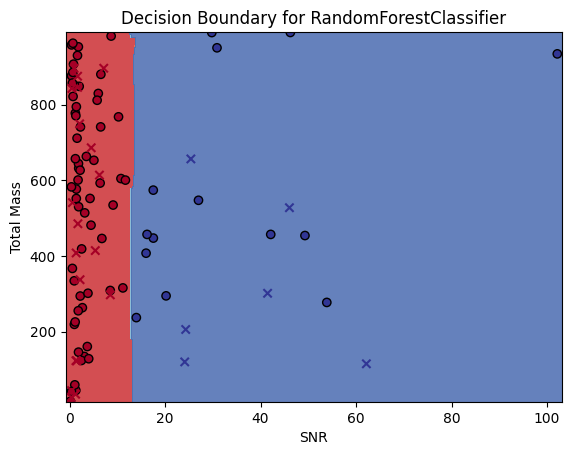

In [5]:
# Define the mesh grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the mesh grid
Z = rf_clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', marker='o', cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='x', cmap=plt.cm.RdYlBu)

plt.xlabel('SNR')
plt.ylabel('Total Mass')
plt.title('Decision Boundary for RandomForestClassifier')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

In [2]:
data = h5py.File('../../sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [3]:
snr = data['snr'][:100]
iota = data['iota'][:100]
mtot= data['mtot'][:100]
q = data['q'][:100]
z = data['z'][:100]
psi = data['psi'][:100]
det =  data['det'][:100]

print(len(snr))

100


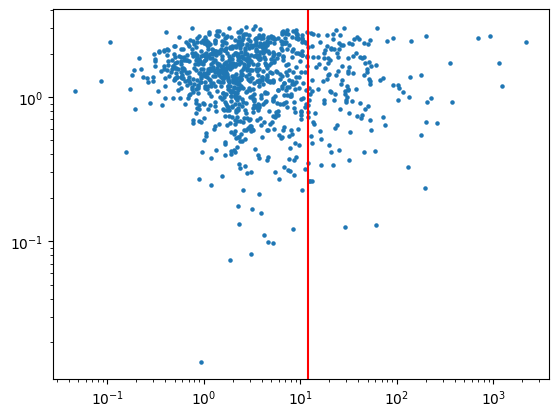

In [5]:
plt.scatter(snr, iota, s= 5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(12, color = 'red')


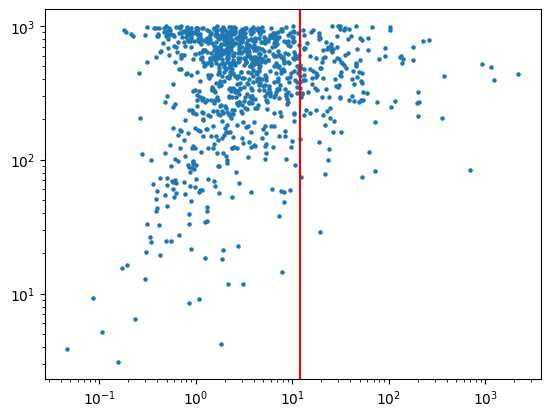

In [11]:
plt.scatter(snr, mtot, s= 5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(12, color = 'red')


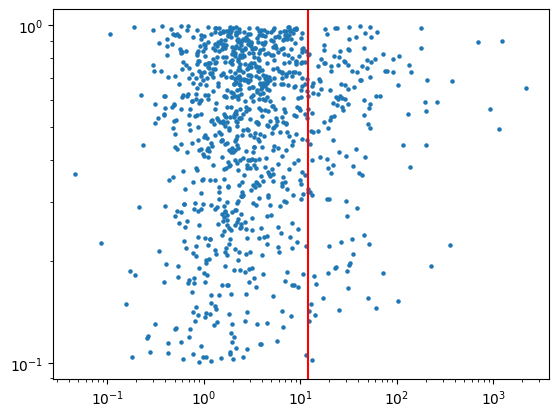

In [12]:
plt.scatter(snr, q, s = 5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(12, color = 'red')


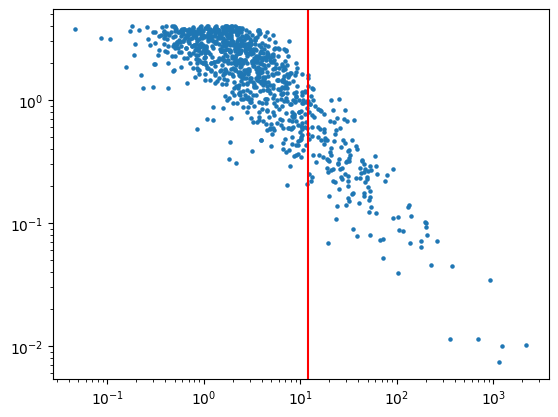

In [13]:
plt.scatter(snr, z, s = 5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(12, color = 'red')


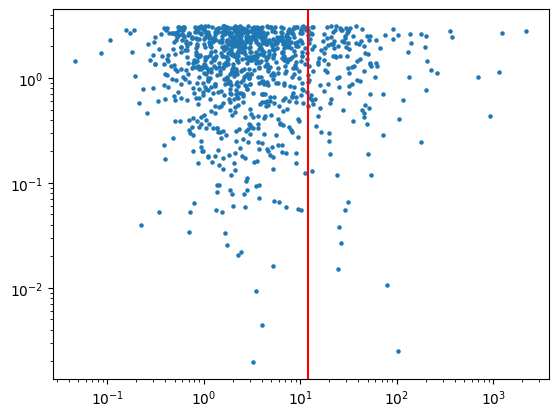

In [14]:
plt.scatter(snr, psi, s = 5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(12, color = 'red')


In [36]:
#----------------------------------------------------------------------
# get data and split into training & testing sets
Xnew = np.array([snr, mtot, iota]).T

print(np.shape(Xnew))
ynew = det
#Xnew = Xnew[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(Xnew, ynew, [0.75, 0.25], random_state=0)

(1000, 3)


completeness [1. 1. 1.]
contamination [0.02439024 0.02439024 0.02439024]


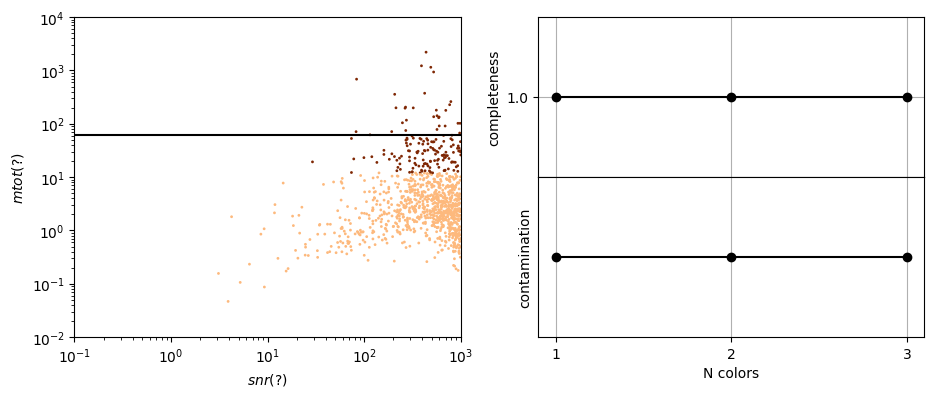

In [45]:

N_tot = len(ynew)
N_st = np.sum(ynew == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, Xnew.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.1, 1000)
ylim = (0.01, 10**4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(Xnew[-N_plot:, 1], Xnew[-N_plot:, 0], c=ynew[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.loglog()
ax.set_xlabel('$snr (?)$')
ax.set_ylabel('$mtot (?)$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()